# Running stDiff on DLPFC data

*   To run stDiff within the notebook, you will need to run the following:

In [ ]:
!python train_interpolate_dlpfc.py --data-file dlpfc.csv --epochs 300 --batch-size 4 --learning-rate 0.001 --output-file ./

*   After running the above cell, all the outputs fro different lambda values will be saved in the current directory.
*   The optimal lambda value which captures the spatial pattern of the target slice will be used for evaluation ( lambda = 0.7 for this dataset)

In [2]:
import anndata as ad
import pandas as pd
import squidpy as sq
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.sparse import issparse

In [3]:
adata =  ad.read_h5ad('./dlpfc_76.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 3431 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'mclust', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'ARI', 'ari', 'domain_colors', 'ground_truth_colors', 'hvg', 'log1p', 'neighbors', 'nmi', 'sc', 'spatial', 'umap'
    obsm: 'X_umap', 'edge_probabilities', 'emb', 'feat', 'graph_neigh', 'img_emb', 'norm_emb', 'spatial'
    obsp: 'connectivities', 'distances'

In [6]:
layer4_interpolated = pd.read_csv('./stdiff_interpolated_dlpfc.csv')

*  extract the layer 4 from the starmap anndata object to use it a ground truth 

In [7]:
adata.obs.ground_truth

AAACAAGTATCTCCCA-1    Layer_3
AAACAATCTACTAGCA-1    Layer_1
AAACACCAATAACTGC-1         WM
AAACAGAGCGACTCCT-1    Layer_3
AAACAGGGTCTATATT-1    Layer_6
                       ...   
TTGTTGTGTGTCAAGA-1    Layer_6
TTGTTTCACATCCAGG-1         WM
TTGTTTCATTAGTCTA-1         WM
TTGTTTCCATACAACT-1    Layer_6
TTGTTTGTGTAAATTC-1    Layer_1
Name: ground_truth, Length: 3431, dtype: category
Categories (7, object): ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']

In [8]:
adatal4 = adata[adata.obs['ground_truth']== 'Layer_4'].copy()

In [9]:
adatal4

AnnData object with n_obs × n_vars = 254 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'mclust', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'dispersions', 'dispersions_norm'
    uns: 'ARI', 'ari', 'domain_colors', 'ground_truth_colors', 'hvg', 'log1p', 'neighbors', 'nmi', 'sc', 'spatial', 'umap'
    obsm: 'X_umap', 'edge_probabilities', 'emb', 'feat', 'graph_neigh', 'img_emb', 'norm_emb', 'spatial'
    obsp: 'connectivities', 'distances'

In [10]:
layer4_interpolated_adata = ad.AnnData(layer4_interpolated)

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
layer4_interpolated_adata.obs = adatal4.obs.copy()
layer4_interpolated_adata.uns = adatal4.uns.copy()
layer4_interpolated_adata.obsm = adatal4.obsm.copy()
layer4_interpolated_adata.var = adatal4.var.copy()

* run leiden clustering on ground truth

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


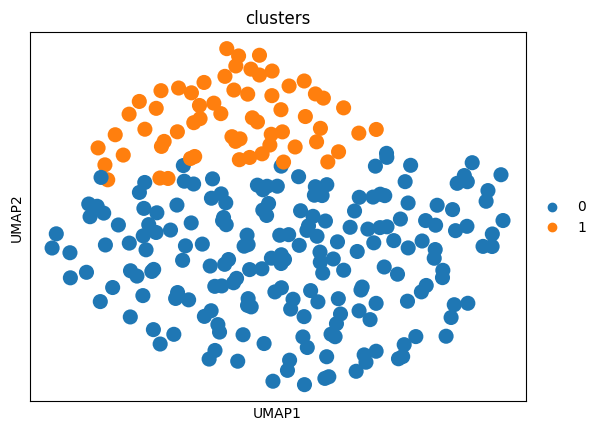

In [19]:
import scanpy as sc
sc.pp.normalize_total(adatal4, target_sum=1e4, inplace=True)
sc.pp.pca(adatal4 , n_comps=15)
sc.pp.neighbors(adatal4)
sc.tl.umap(adatal4)
sc.tl.leiden(adatal4 , key_added="clusters", resolution=0.5)
sc.pl.umap(adatal4, color="clusters")
#sc.pl.embedding(adatal4, basis="spatial", color="clusters", cmap='plasma')

* run leiden clustering on interpolated data generated with stDiff

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


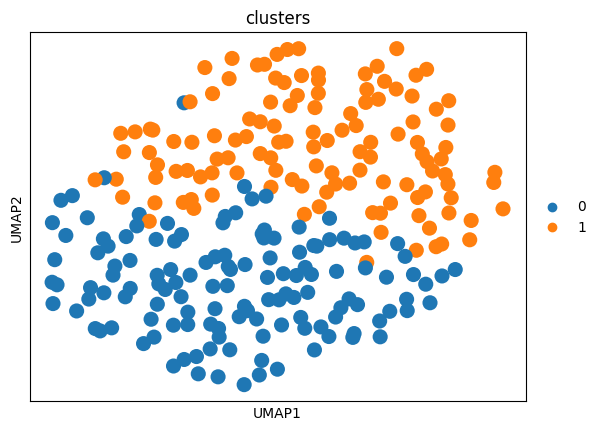

In [20]:
import scanpy as sc
sc.pp.normalize_total(layer4_interpolated_adata, target_sum=1e4, inplace=True)
sc.pp.pca(layer4_interpolated_adata , n_comps=15)
sc.pp.neighbors(layer4_interpolated_adata)
sc.tl.umap(layer4_interpolated_adata)
sc.tl.leiden(layer4_interpolated_adata , key_added="clusters", resolution=0.5)
sc.pl.umap(layer4_interpolated_adata, color="clusters")
#sc.pl.embedding(layer4_interpolated_adata, basis="spatial", color="clusters", cmap='plasma')

* calculate the spearman correlation between the ground truth and interpolated data and plot along the spatial coordinates

Average Normalized Spearman Correlation: 0.526939158435434


Text(0.5, 1.0, 'Spearman Correlation Interpolation (SpatialDiffusion)')

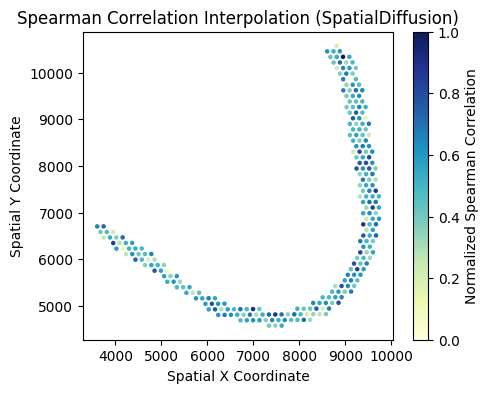

In [17]:
# Extract the expression matrices
ground_truth_expr = adatal4.X.toarray() if issparse(adatal4.X) else adatal4.X
interpolated_expr = layer4_interpolated_adata.X.toarray() if issparse(layer4_interpolated_adata.X) else layer4_interpolated_adata.X

# Calculate Spearman correlation for each spot
spearman_correlations_per_spot = [
    spearmanr(ground_truth_expr[i, :], interpolated_expr[i, :])[0]
    for i in range(ground_truth_expr.shape[0])
]

# Normalize the Spearman correlation values for color mapping
normalized_correlations = (np.array(spearman_correlations_per_spot) - np.min(spearman_correlations_per_spot)) / (np.max(spearman_correlations_per_spot) - np.min(spearman_correlations_per_spot))

average_normalized_correlation = np.mean(normalized_correlations)

print("Average Normalized Spearman Correlation:", average_normalized_correlation)

# Extract spatial coordinates
ground_truth_coords = adatal4.obsm['spatial']

# Plot
plt.figure(figsize=(5, 4)) #$ 10, 8
sc = plt.scatter(ground_truth_coords[:, 0], ground_truth_coords[:, 1], c=normalized_correlations, cmap='YlGnBu', s=5)
plt.colorbar(sc, label='Normalized Spearman Correlation')
plt.xlabel('Spatial X Coordinate')
plt.ylabel('Spatial Y Coordinate')
plt.title('Spearman Correlation Interpolation (SpatialDiffusion)')

Text(0.5, 0, 'Normalized Spearman Correlation')

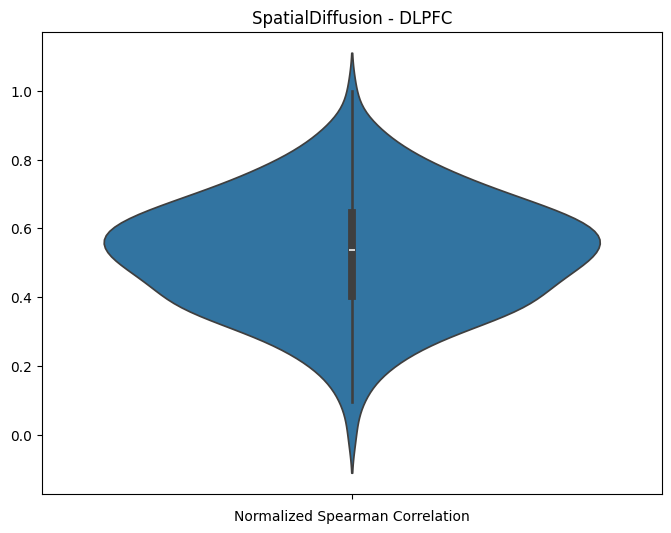

In [23]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.violinplot(data=normalized_correlations)
plt.title('SpatialDiffusion - DLPFC')
plt.xlabel('Normalized Spearman Correlation')


In [24]:
linear_interpolated = pd.read_csv('./LinearInterpolationL4.csv')

/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/Flows/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


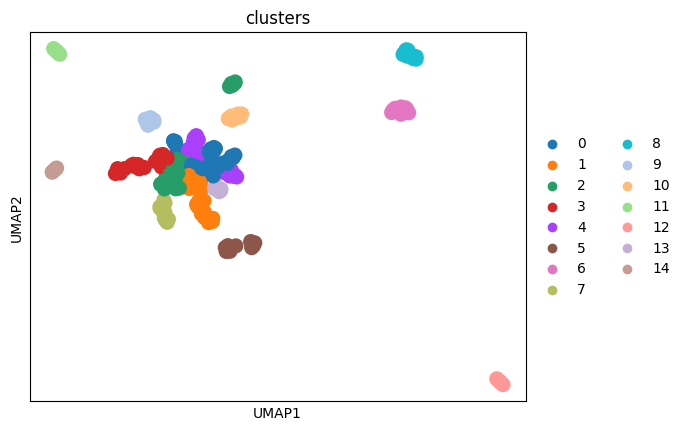

In [26]:
linear_interpolated_adata = ad.AnnData(linear_interpolated)
linear_interpolated_adata.obs = adatal4.obs.copy()
linear_interpolated_adata.uns = adatal4.uns.copy()
linear_interpolated_adata.obsm = adatal4.obsm.copy()
linear_interpolated_adata.var = adatal4.var.copy()
sc.pp.normalize_total(linear_interpolated_adata, target_sum=1e4, inplace=True)
sc.pp.pca(linear_interpolated_adata , n_comps=15)
sc.pp.neighbors(linear_interpolated_adata)
sc.tl.umap(linear_interpolated_adata)
sc.tl.leiden(linear_interpolated_adata , key_added="clusters", resolution=0.5)
sc.pl.umap(linear_interpolated_adata, color="clusters")


Average Normalized Spearman Correlation: 0.4991168349116107


Text(0.5, 1.0, 'Spearman Correlation Interpolation (Linear)')

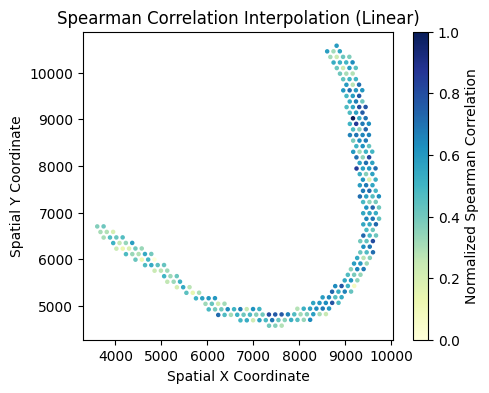

In [27]:
# Extract the expression matrices
ground_truth_expr = adatal4.X.toarray() if issparse(adatal4.X) else adatal4.X
interpolated_expr = linear_interpolated_adata.X.toarray() if issparse(linear_interpolated_adata.X) else linear_interpolated_adata.X

# Calculate Spearman correlation for each spot
spearman_correlations_per_spot = [
    spearmanr(ground_truth_expr[i, :], interpolated_expr[i, :])[0]
    for i in range(ground_truth_expr.shape[0])
]

# Normalize the Spearman correlation values for color mapping
normalized_correlations = (np.array(spearman_correlations_per_spot) - np.min(spearman_correlations_per_spot)) / (np.max(spearman_correlations_per_spot) - np.min(spearman_correlations_per_spot))

average_normalized_correlation = np.mean(normalized_correlations)

print("Average Normalized Spearman Correlation:", average_normalized_correlation)

# Extract spatial coordinates
ground_truth_coords = adatal4.obsm['spatial']

# Plot
plt.figure(figsize=(5, 4)) #$ 10, 8
sc = plt.scatter(ground_truth_coords[:, 0], ground_truth_coords[:, 1], c=normalized_correlations, cmap='YlGnBu', s=5)
plt.colorbar(sc, label='Normalized Spearman Correlation')
plt.xlabel('Spatial X Coordinate')
plt.ylabel('Spatial Y Coordinate')
plt.title('Spearman Correlation Interpolation (Linear)')

Text(0.5, 0, 'Normalized Spearman Correlation')

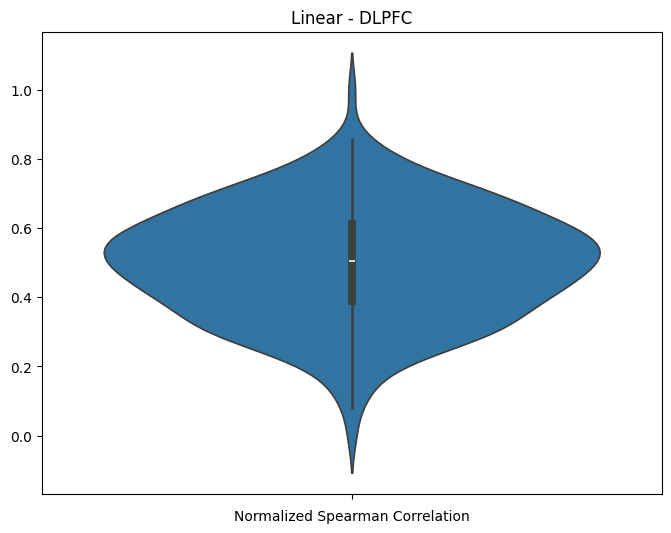

In [28]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=normalized_correlations)
plt.title('Linear - DLPFC')
plt.xlabel('Normalized Spearman Correlation')